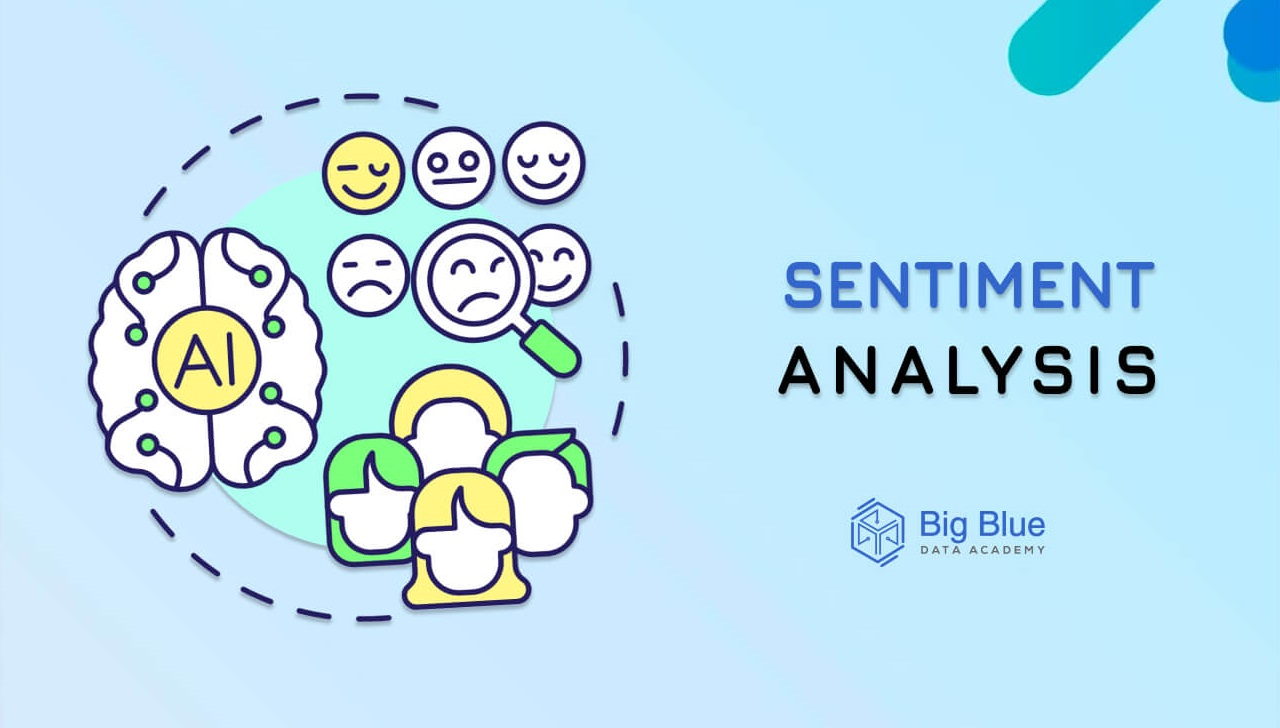
# **SENTIMENT ANALYSIS**

BY:-

*   ASHISH SAINI - 21CSU259
*   ADITYA - 21CSU272
*   SHUBHKIRTI - 21CSU273
*   YASHIKA GREWAL - 21CSU274

## IMPORTING LIBRARIES AND DATASET

In [1]:
pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType, StructType, StructField, StringType, IntegerType, MapType, DoubleType
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import sum, when, col
from pyspark.sql.functions import lower, explode, split
from pyspark.sql.functions import length
import seaborn as sns
from wordcloud import WordCloud
from pyspark.sql.functions import from_unixtime
from transformers import pipeline
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
from pyspark.ml.feature import NGram
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

LOADING NLTK RESOURCES

In [3]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

INITIALIZING SPARKSESSION

In [4]:
spark = SparkSession.builder \
    .appName("Sentiment_Analysis") \
    .getOrCreate()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


READING CSV INTO SPARK DATA FRAME

In [5]:
schema = StructType([
    StructField("Id", IntegerType(), True),
    StructField("ProductId", StringType(), True),
    StructField("UserId", StringType(), True),
    StructField("ProfileName", StringType(), True),
    StructField("HelpfulnessNumerator", IntegerType(), True),
    StructField("HelpfulnessDenominator", IntegerType(), True),
    StructField("Score", IntegerType(), True),
    StructField("Time", IntegerType(), True),
    StructField("Summary", StringType(), True),
    StructField("Text", StringType(), True)
])
df = spark.read.csv("/content/Reviews.csv", header=True, schema=schema)

## EXPLORING AND PREPROCESSING THE DATASET

In [6]:
print("Original DataFrame shape:", (df.count(), len(df.columns)))

Original DataFrame shape: (262085, 10)


In [7]:
df.show()

+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
| Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|
+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
|  1|B001E4KFG0|A3SGXH7AUHU8GW|          delmartian|                   1|                     1|    5|1303862400|Good Quality Dog ...|I have bought sev...|
|  2|B00813GRG4|A1D87F6ZCVE5NK|              dll pa|                   0|                     0|    1|1346976000|   Not as Advertised|"Product arrived ...|
|  3|B000LQOCH0| ABXLMWJIXXAIN|"Natalia Corres "...|                   1|                     1|    4|1219017600|"""Delight"" says...|"This is a confec...|
|  4|B000UA0QIQ|A395BORC6FGVXV|                Karl|            

In [8]:
df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: integer (nullable = true)
 |-- HelpfulnessDenominator: integer (nullable = true)
 |-- Score: integer (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)



In [9]:
df.columns

['Id',
 'ProductId',
 'UserId',
 'ProfileName',
 'HelpfulnessNumerator',
 'HelpfulnessDenominator',
 'Score',
 'Time',
 'Summary',
 'Text']

MISSING VALUE ANALYSIS AND OUTLIER REMOVAL

In [10]:
# Remove outliers
# Count the number of rows before filtering
original_count = df.count()

# Filter the DataFrame based on the "Score" column
filtered_df = df.filter((col("Score") >= 0) & (col("Score") <= 5))

# Count the number of rows after filtering
filtered_count = filtered_df.count()

# Calculate the number of removed rows
removed_count = original_count - filtered_count

print("Number of rows removed:", removed_count)

# Show the rows that have been removed
removed_rows = df.subtract(filtered_df)
print("Removed rows:")
removed_rows.show()

Number of rows removed: 277
Removed rows:
+------+----------+--------------+--------------------+--------------------+----------------------+-----+----+----------+--------------------+
|    Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|Time|   Summary|                Text|
+------+----------+--------------+--------------------+--------------------+----------------------+-----+----+----------+--------------------+
|  8077|B0012KB4M0|A21JYO15M2PET8|"Karl A. Jeney ""...|                NULL|                  NULL|    6|  12|         1|          1298678400|
| 33504|B006N3I84I|A3UCN2RGY7O6S1| "Joanne ""Gotta Eat|                NULL|                    32|   33|   5|1230940800|"This is ""the on...|
| 73998|B004JRKEH4|A37NODCIL8PP75|"Jeannette Belliv...|                NULL|                  NULL| NULL|   0|         0|                   3|
|127690|B001BOVE54| AJD41FBJD9010|  "N. Ferguson ""Two|                NULL|                  NULL| 

In [11]:
# Compute the count of missing values for each column
missing_counts = df.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])

# Calculate the percentage of missing values for each column
total_rows = df.count()
missing_percentages = [(missing_count / total_rows * 100) for missing_count in missing_counts.collect()[0]]

# Print the missing data analysis
print("Missing data analysis:")
for col_name, percentage in zip(df.columns, missing_percentages):
    print(f"{col_name}: {percentage:.2f}%")

Missing data analysis:
Id: 0.00%
ProductId: 0.00%
UserId: 0.00%
ProfileName: 0.00%
HelpfulnessNumerator: 0.52%
HelpfulnessDenominator: 0.17%
Score: 0.06%
Time: 0.00%
Summary: 0.00%
Text: 0.00%


In [12]:
# Check the new shape of the DataFrame
print("DataFrame shape after removal of ouliers:", (df.count(), len(df.columns)))

DataFrame shape after removal of ouliers: (262085, 10)


## VISUALIZATION

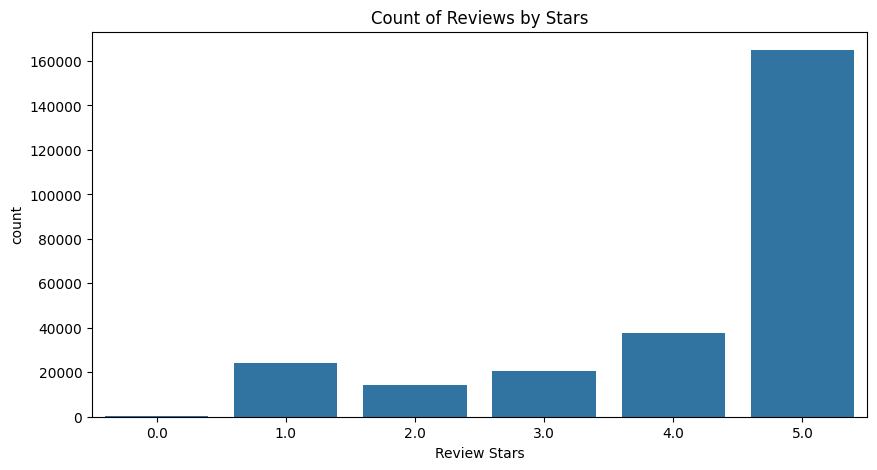

In [13]:
score_counts = df.groupBy("Score").count().orderBy("Score").toPandas()
score_counts_filtered = score_counts[score_counts["Score"] <= 5]

plt.figure(figsize=(10, 5))
sns.barplot(x="Score", y="count", data=score_counts_filtered)
plt.title("Count of Reviews by Stars")
plt.xlabel("Review Stars")
plt.show()

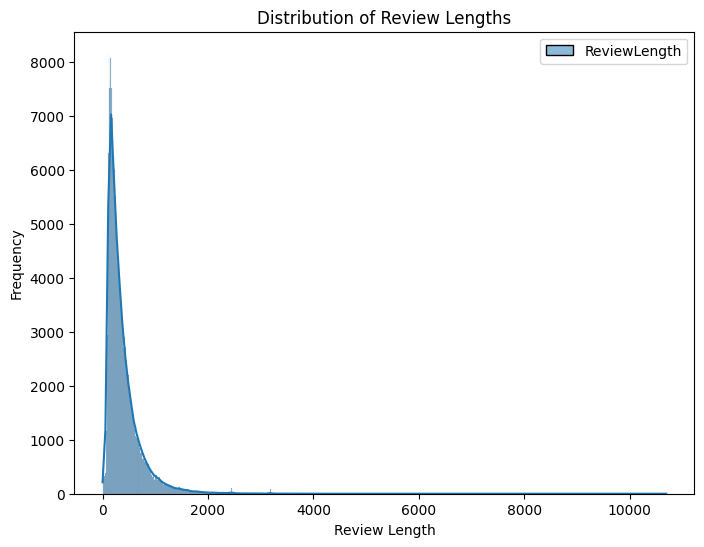

In [14]:
# Compute the length of each review
df = df.withColumn("ReviewLength", length(col("Text")))

# Plot the distribution of review lengths
plt.figure(figsize=(8, 6))
sns.histplot(df.select("ReviewLength").toPandas(), kde=True, color='salmon')
plt.xlabel("Review Length")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

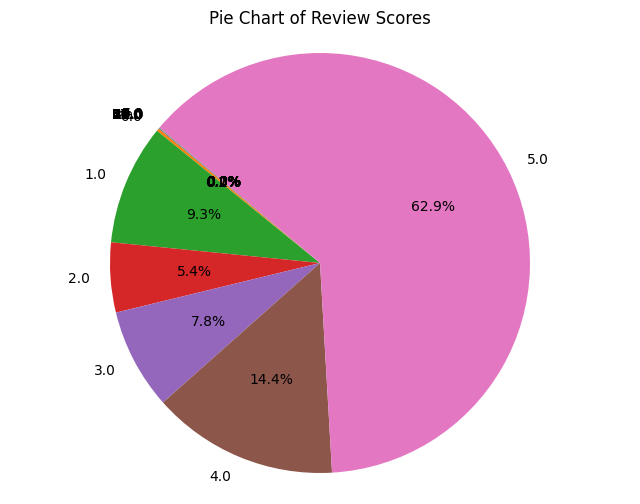

In [15]:
# Plot a pie chart of review scores
plt.figure(figsize=(8, 6))
plt.pie(score_counts["count"], labels=score_counts["Score"], autopct='%1.1f%%', startangle=140)
plt.title("Pie Chart of Review Scores")
plt.axis('equal')
plt.show()

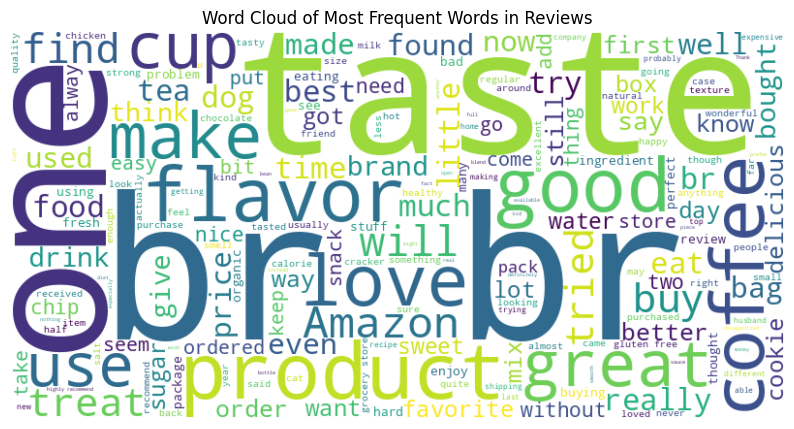

In [16]:
# Generate word cloud
text = " ".join(review for review in df.select("Text").toPandas()["Text"])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words in Reviews')
plt.show()

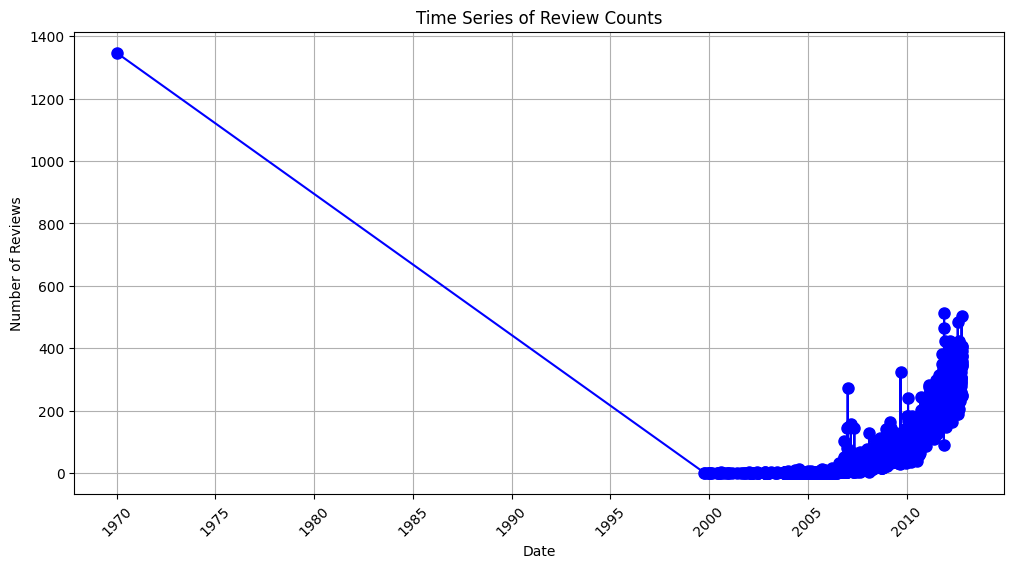

In [16]:
# Convert Unix timestamp to Date
df = df.withColumn("Date", from_unixtime("Time").cast("date"))

# Group by Date and count the number of reviews for each date
date_counts = df.groupBy("Date").count().orderBy("Date").toPandas()

# Plot the time series of review counts with more defined points
plt.figure(figsize=(12, 6))
plt.plot(date_counts["Date"], date_counts["count"], marker='o', linestyle='-', markersize=8, color='b')
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.title("Time Series of Review Counts")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

<ipython-input-17-529088cec6ea>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=word_counts.head(50), x="Words", y="count", palette="coolwarm")


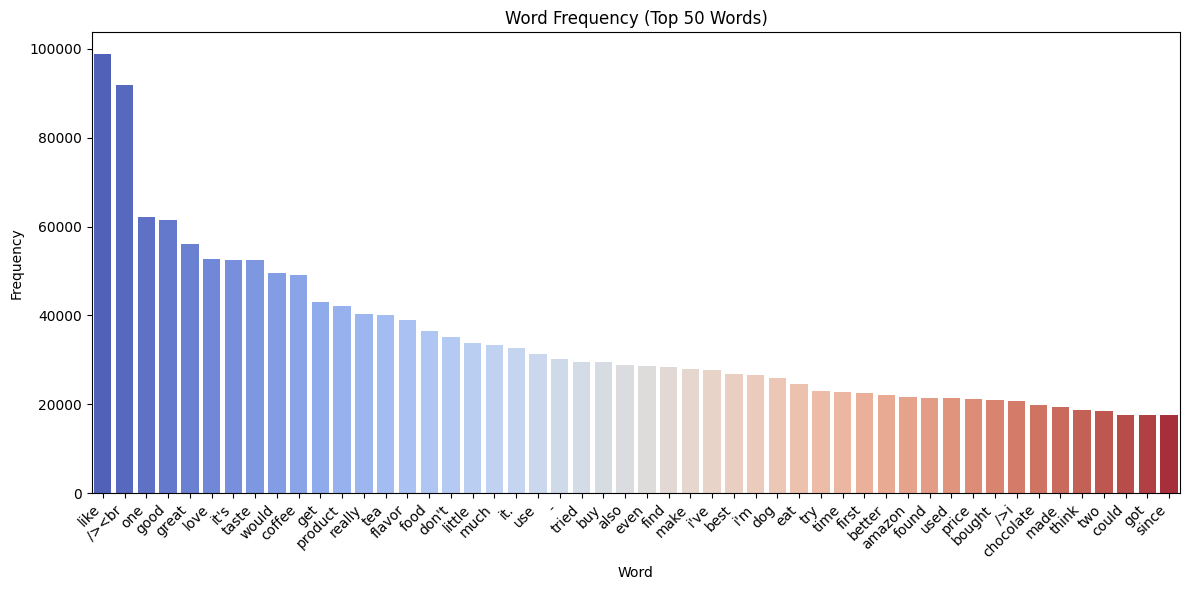

In [17]:
# Tokenize and lowercase the text column
df = df.withColumn("Words", explode(split(lower(col("Text")), "\\s+")))

# Filter out common stop words
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
df = df.filter(~col("Words").isin(stop_words))

# Group by Word, count the number of occurrences for each word
word_counts = df.groupBy("Words").count().orderBy("count", ascending=False).toPandas()

# Plot the word frequency for the top 50 words
plt.figure(figsize=(12, 6))
sns.barplot(data=word_counts.head(50), x="Words", y="count", palette="coolwarm")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Word Frequency (Top 50 Words)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

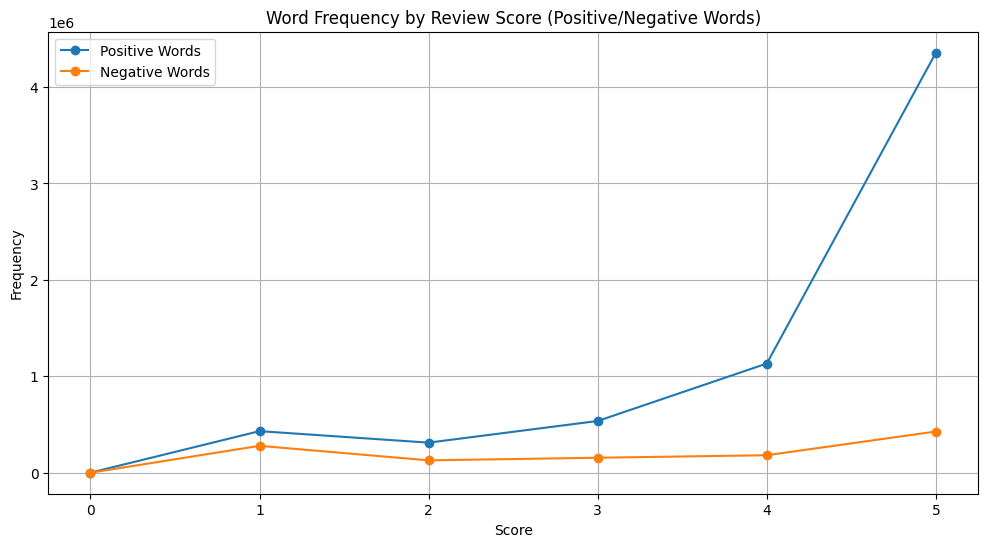

In [18]:
# Filter out common stop words
positive_words = ["good", "great", "excellent", "love", "awesome", "amazing", "fantastic"]
negative_words = ["bad", "poor", "terrible", "awful", "horrible", "disappointing"]

# Count positive and negative word occurrences by score (restricted to Score == 5)
positive_counts = df.filter(col("Score") <= 5).filter(lower(col("Text")).rlike("|".join(positive_words))).groupBy("Score").count().orderBy("Score").toPandas()
negative_counts = df.filter(col("Score") <= 5).filter(lower(col("Text")).rlike("|".join(negative_words))).groupBy("Score").count().orderBy("Score").toPandas()

# Plot the word frequency by review score
plt.figure(figsize=(12, 6))
plt.plot(positive_counts["Score"], positive_counts["count"], marker='o', linestyle='-', label='Positive Words')
plt.plot(negative_counts["Score"], negative_counts["count"], marker='o', linestyle='-', label='Negative Words')
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Word Frequency by Review Score (Positive/Negative Words)")
plt.legend()
plt.grid(True)
plt.show()

## SENTIMENT ANALYSIS THROUGH NTLK

In [19]:
# Show example text
example_text_sample = df.select("Text").take(1)[0][0]
print(example_text_sample)

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


In [20]:
# Tokenize
tokens = nltk.word_tokenize(example_text_sample)

# Part-of-Speech Tagging
tagged = nltk.pos_tag(tokens)

# Print tagged tokens
print(tagged)

[('I', 'PRP'), ('have', 'VBP'), ('bought', 'VBN'), ('several', 'JJ'), ('of', 'IN'), ('the', 'DT'), ('Vitality', 'NNP'), ('canned', 'VBD'), ('dog', 'RP'), ('food', 'NN'), ('products', 'NNS'), ('and', 'CC'), ('have', 'VBP'), ('found', 'VBN'), ('them', 'PRP'), ('all', 'DT'), ('to', 'TO'), ('be', 'VB'), ('of', 'IN'), ('good', 'JJ'), ('quality', 'NN'), ('.', '.'), ('The', 'DT'), ('product', 'NN'), ('looks', 'VBZ'), ('more', 'RBR'), ('like', 'IN'), ('a', 'DT'), ('stew', 'NN'), ('than', 'IN'), ('a', 'DT'), ('processed', 'JJ'), ('meat', 'NN'), ('and', 'CC'), ('it', 'PRP'), ('smells', 'VBZ'), ('better', 'RBR'), ('.', '.'), ('My', 'PRP$'), ('Labrador', 'NNP'), ('is', 'VBZ'), ('finicky', 'JJ'), ('and', 'CC'), ('she', 'PRP'), ('appreciates', 'VBZ'), ('this', 'DT'), ('product', 'NN'), ('better', 'JJR'), ('than', 'IN'), ('most', 'JJS'), ('.', '.')]


In [21]:
# Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Compute sentiment scores for the first 1000 rows
res = {}
for row in tqdm(df.limit(1000).collect()):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

# Create DataFrame from results
vaders = spark.createDataFrame(list(res.items()), ['Id', 'sentiment_scores'])

# Merge sentiment scores with original DataFrame
vaders = vaders.join(df, on='Id', how='left')

100%|██████████| 1000/1000 [00:01<00:00, 645.73it/s]


In [22]:
vaders.show()

+---+--------------------+----------+--------------+-----------------+--------------------+----------------------+-----+----------+--------------------+--------------------+------------+----------+------------+
| Id|    sentiment_scores| ProductId|        UserId|      ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|ReviewLength|      Date|       Words|
+---+--------------------+----------+--------------+-----------------+--------------------+----------------------+-----+----------+--------------------+--------------------+------------+----------+------------+
|  7|{neg -> 0.034, po...|B006K2ZZ7K|A1SP2KVKFXXRU1|David C. Sullivan|                   0|                     0|    5|1340150400|Great!  Just as g...|This saltwater ta...|         304|2012-06-20|   saltwater|
|  7|{neg -> 0.034, po...|B006K2ZZ7K|A1SP2KVKFXXRU1|David C. Sullivan|                   0|                     0|    5|1340150400|Great!  Just as g...|This

In [26]:
# Filter DataFrame to include scores up to 5
vaders_filtered = vaders.filter(vaders['Score'] <= 5).toPandas()

# Check the structure of the DataFrame
print(vaders_filtered.columns)

Index(['Id', 'sentiment_scores', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'ReviewLength', 'Date', 'Words'],
      dtype='object')


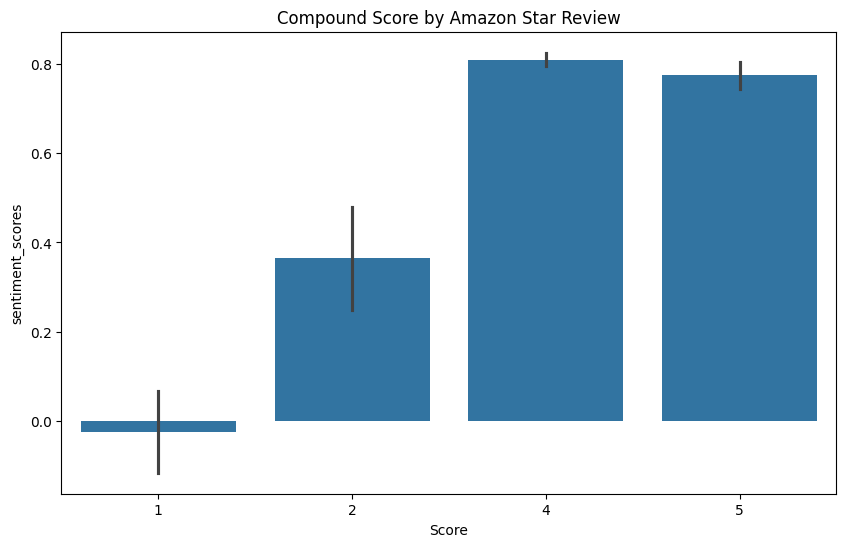

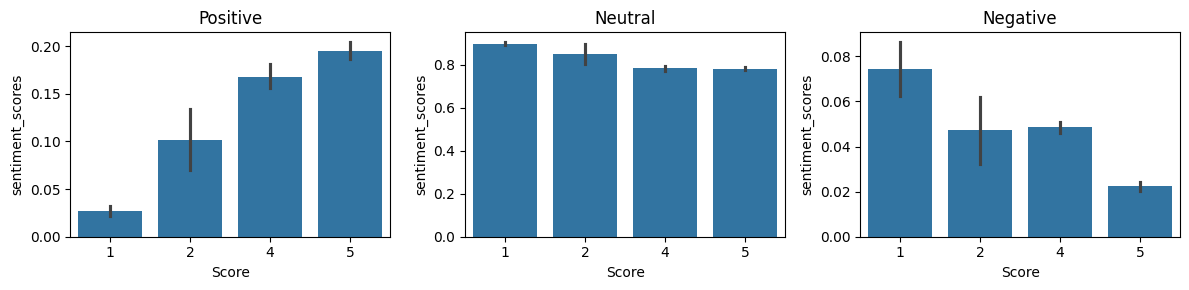

In [27]:
# Compound Score by Amazon Star Review
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=vaders_filtered, x='Score', y=vaders_filtered['sentiment_scores'].apply(lambda x: x['compound']))
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

# Positive, Neutral, and Negative Scores by Amazon Star Review
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# Plot positive scores
sns.barplot(data=vaders_filtered, x='Score', y=vaders_filtered['sentiment_scores'].apply(lambda x: x['pos']), ax=axs[0])
axs[0].set_title('Positive')

# Plot neutral scores
sns.barplot(data=vaders_filtered, x='Score', y=vaders_filtered['sentiment_scores'].apply(lambda x: x['neu']), ax=axs[1])
axs[1].set_title('Neutral')

# Plot negative scores
sns.barplot(data=vaders_filtered, x='Score', y=vaders_filtered['sentiment_scores'].apply(lambda x: x['neg']), ax=axs[2])
axs[2].set_title('Negative')

plt.tight_layout()
plt.show()

In [28]:
# RoBERTa Model and Tokenizer
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [29]:
# Function to compute RoBERTa sentiment scores
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output.logits.softmax(dim=1).detach().numpy()[0]
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [30]:
# Compute sentiment scores using both VADER and RoBERTa
res = {}
for row in tqdm(df.limit(1000).collect()):  # Limiting to 1000 rows for efficiency
    text = row['Text']
    myid = row['Id']
    try:
        vader_result = sia.polarity_scores(text)
        roberta_result = polarity_scores_roberta(text)
        both = {f"vader_{key}": value for key, value in vader_result.items()}
        both.update(roberta_result)
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

# Create DataFrame from results
results_df = spark.createDataFrame(pd.DataFrame(res).T.reset_index().rename(columns={'index': 'Id'}))

# Merge sentiment scores with original DataFrame
results_df = results_df.join(df, on='Id', how='left')

100%|██████████| 1000/1000 [11:09<00:00,  1.49it/s]


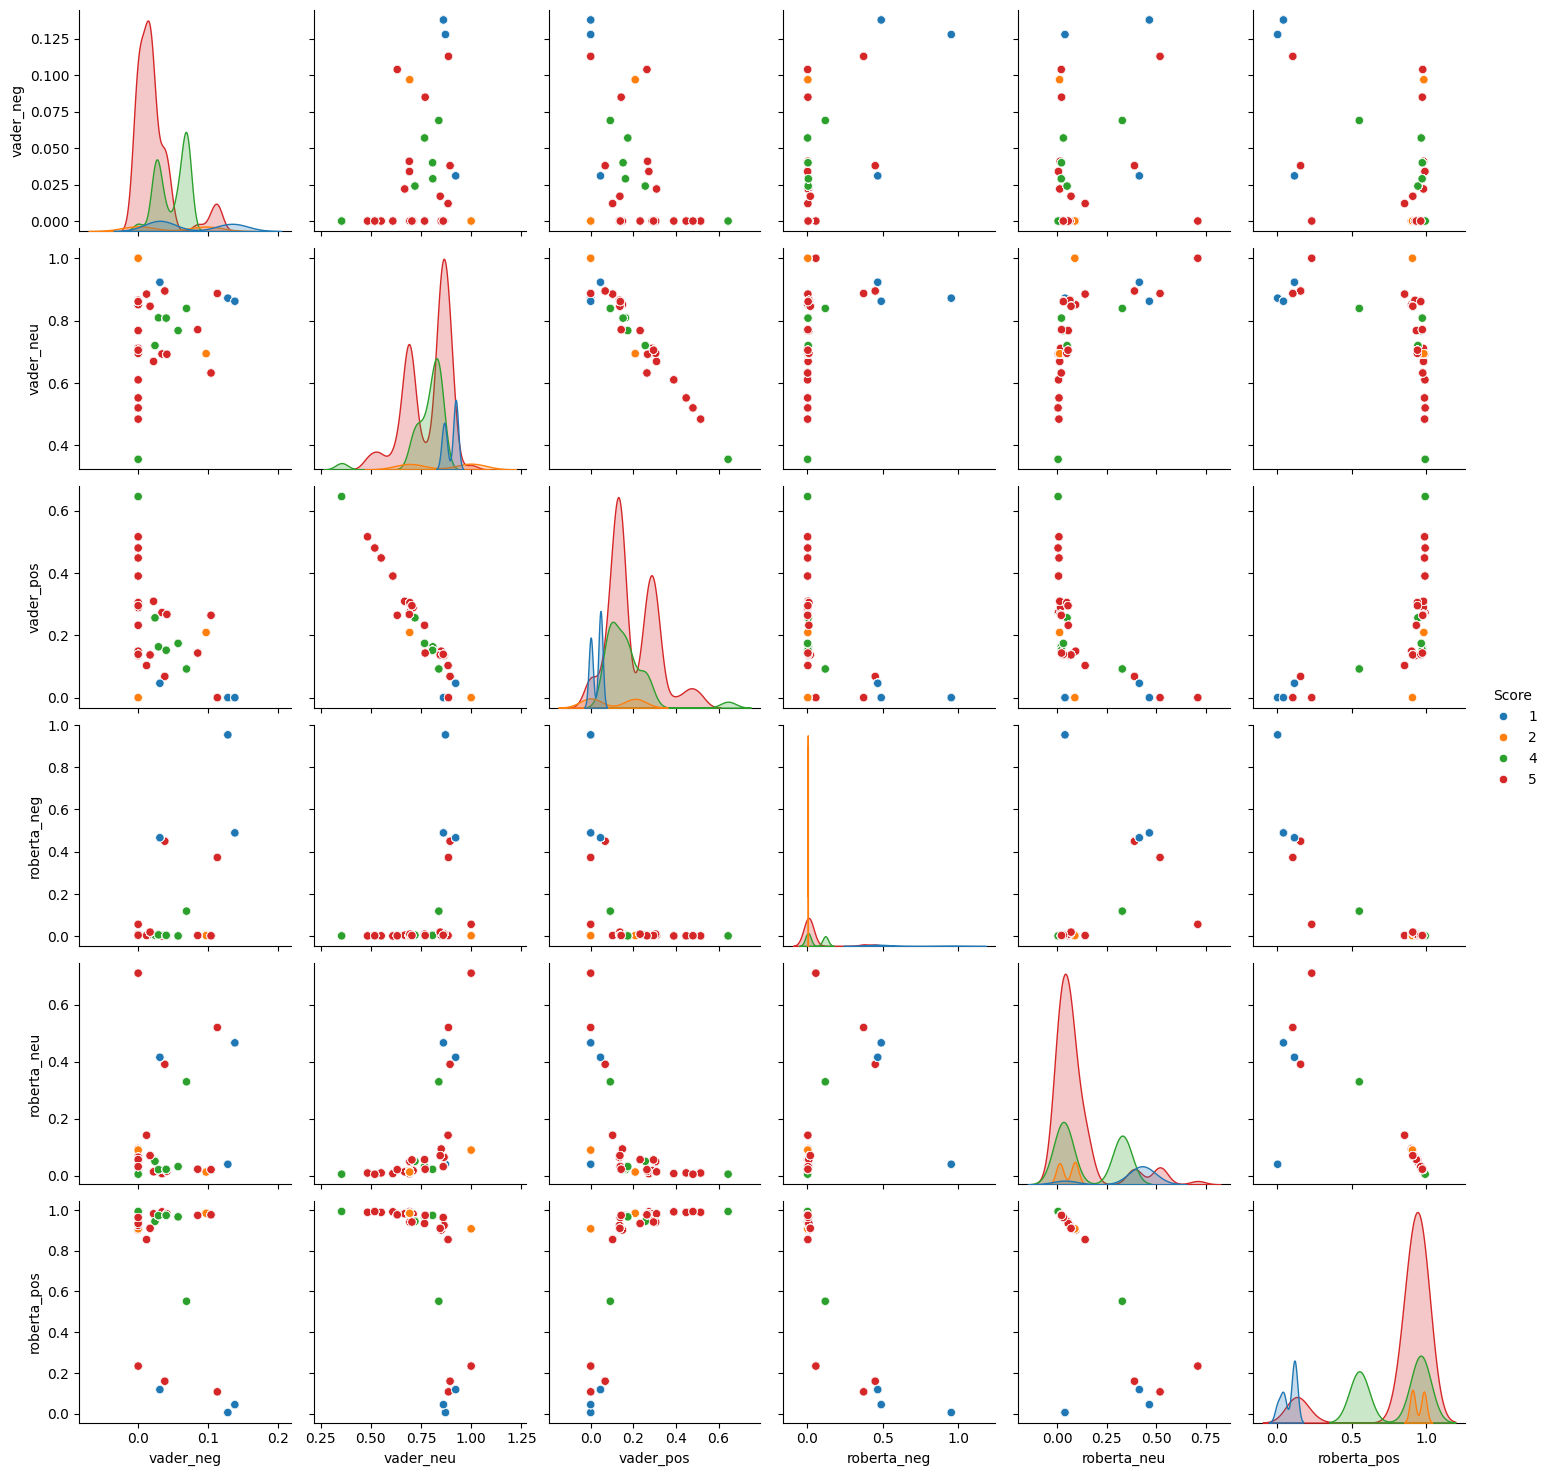

In [31]:
# Pairplot for sentiment scores
sns.pairplot(data=results_df.toPandas(),
             vars=['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='Score',
             palette='tab10')
plt.show()

In [32]:
# Top positive review text for Score 1 (using RoBERTa)
print(results_df.filter(results_df['Score'] == 1).sort('roberta_pos', ascending=False).select('Text').collect()[0]['Text'])

# Top positive review text for Score 1 (using VADER)
print(results_df.filter(results_df['Score'] == 1).sort('vader_pos', ascending=False).select('Text').collect()[0]['Text'])

# Top negative review text for Score 5 (using RoBERTa)
print(results_df.filter(results_df['Score'] == 5).sort('roberta_neg', ascending=False).select('Text').collect()[0]['Text'])

# Top negative review text for Score 5 (using VADER)
print(results_df.filter(results_df['Score'] == 5).sort('vader_neg', ascending=False).select('Text').collect()[0]['Text'])

My cats have been happily eating Felidae Platinum for more than two years. I just got a new bag and the shape of the food is different. They tried the new food when I first put it in their bowls and now the bowls sit full and the kitties will not touch the food. I've noticed similar reviews related to formula changes in the past. Unfortunately, I now need to find a new food that my cats will eat.
My cats have been happily eating Felidae Platinum for more than two years. I just got a new bag and the shape of the food is different. They tried the new food when I first put it in their bowls and now the bowls sit full and the kitties will not touch the food. I've noticed similar reviews related to formula changes in the past. Unfortunately, I now need to find a new food that my cats will eat.
I have lived out of the US for over 7 yrs now, and I so miss my Twizzlers!!  When I go back to visit or someone visits me, I always stock up.  All I can say is YUM!<br />Sell these in Mexico and you w

In [33]:
# Sentiment analysis using Hugging Face pipeline
sent_pipeline = pipeline("sentiment-analysis")

# Sample texts
texts = ['I love sentiment analysis!',
         'Make sure to like and subscribe!',
         'booo']

# Perform sentiment analysis
for text in texts:
    result = sent_pipeline(text)
    print(result)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]
[{'label': 'POSITIVE', 'score': 0.9991742968559265}]
[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]


In [34]:
# Stop SparkSession
spark.stop()